In [19]:
# Libaries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [3]:
# Define the new working directory path
new_working_directory = r'/Users/nicol1/Documents/GitHub/sports-data'

# Change the current working directory
os.chdir(new_working_directory)

In [4]:
# Define the path 
data_folder = 'data/'

# Load the CSV files to df
cleaned_df = pd.read_csv(data_folder + 'cleaned_df.csv')
cleaned_df

,player_id,name,country,height,foot,position,highest_market_value,current_club_domestic_competition_id,number_games_played,total_minutes,...,red_cards_sum,red_cards_avg,goals,avg_goals_per_game,assists,age,year,avg_games_per_year,avg_goals_per_year,avg_assists_per_year
0,122011,Markus Henriksen,Norway,187.0,right,Defender,5000000.0,GB1,165,12199,...,1,0.006061,33,0.200000,22,45.0,6,27.500000,5.500000,3.666667
1,14940,Razvan Rat,Romania,179.0,left,Defender,6500000.0,ES1,97,7690,...,1,0.010309,3,0.030928,13,43.0,5,19.400000,0.600000,2.600000
2,14942,Darijo Srna,Croatia,182.0,right,Defender,17500000.0,IT1,227,19598,...,2,0.008811,22,0.096916,68,45.0,8,28.375000,2.750000,8.500000
3,26267,Fernandinho,Brazil,179.0,right,Midfield,32000000.0,GB1,399,30325,...,3,0.007519,29,0.072682,41,42.0,11,36.272727,2.636364,3.727273
4,55735,Henrikh Mkhitaryan,Armenia,177.0,both,Midfield,37000000.0,IT1,485,35878,...,0,0.000000,128,0.263918,119,43.0,13,37.307692,9.846154,9.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8071,941869,Yellu Santiago,Spain,192.0,right,Midfield,100000.0,ES1,3,153,...,0,0.000000,0,0.000000,0,26.0,1,3.000000,0.000000,0.000000
8072,667991,Alaa Bellaarouch,Morocco,188.0,right,Goalkeeper,200000.0,FR1,1,90,...,0,0.000000,0,0.000000,0,27.0,1,1.000000,0.000000,0.000000
8073,405690,Ole Pohlmann,Germany,183.0,right,Midfield,700000.0,L1,1,31,...,0,0.000000,0,0.000000,0,26.0,1,1.000000,0.000000,0.000000
8074,225963,Lautaro Giannetti,Argentina,185.0,right,Defender,5000000.0,IT1,1,90,...,0,0.000000,0,0.000000,0,27.0,1,1.000000,0.000000,0.000000


In [15]:
# Filter the position for goalkeeper
goalkeeper_df = cleaned_df[cleaned_df['position'] == 'Goalkeeper']
goalkeeper_df
#print(goalkeeper_df.head)

# drop NaN values
goalkeeper_df = goalkeeper_df.dropna()

# Fairplay index
yellow_card_weight = 1
red_card_weight = 3

composite_score = goalkeeper_df['yellow_cards_avg'] * yellow_card_weight + goalkeeper_df['red_cards_avg'] * red_card_weight
fairplay_index = (composite_score - composite_score.min()) / (composite_score.max() - composite_score.min())
goalkeeper_df['fairplay_index'] = fairplay_index

In [16]:
# Select only numeric columns
col_remove = ['player_id', 'highest_market_value']
goalkeeper_df_without = goalkeeper_df.drop(columns = col_remove)
numeric_columns = goalkeeper_df_without.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = numeric_columns.corr()

# Print corr matrix
print(correlation_matrix)



                        height  number_games_played  total_minutes  \
height                1.000000             0.088141       0.089200   
number_games_played   0.088141             1.000000       0.999950   
total_minutes         0.089200             0.999950       1.000000   
average_minutes       0.066576             0.198638       0.201127   
yellow_cards_sum      0.056765             0.815114       0.813989   
yellow_cards_avg      0.002286            -0.019480      -0.019488   
red_cards_sum        -0.090434             0.496678       0.492729   
red_cards_avg        -0.041889            -0.022312      -0.023006   
goals                 0.055689             0.108446       0.108753   
avg_goals_per_game    0.053421             0.093507       0.093739   
assists               0.039288             0.512598       0.512318   
age                  -0.078292             0.382977       0.381145   
year                  0.103094             0.876582       0.875172   
avg_games_per_year  

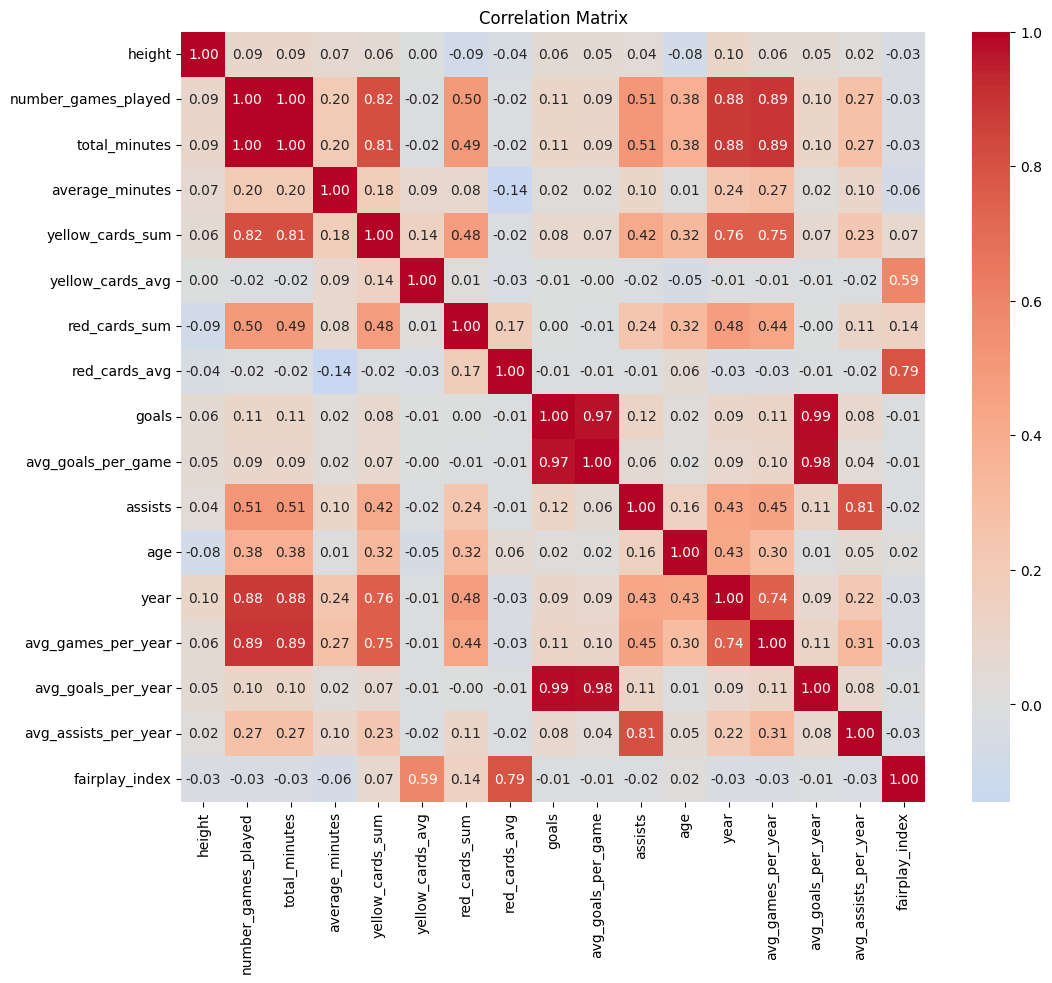

In [17]:
# Plotting correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('Correlation Matrix')
plt.show()

#Notes to Correlation Matrix:
We have a correlation of 1 for total minutes and number of games played = keep total minutes
everything with goals and assist we can remove 


Keep: total minutes, avg_games_per_year, age, year, avg_games_per_year, fairplay_index, avg_minutes



In [18]:

# Divide data into IV (X) y DV (y)
X = goalkeeper_df[['total_minutes', 'average_minutes', 
          'age', 'year', 'avg_games_per_year', ]]
y = goalkeeper_df['highest_market_value']

# Divide data into trial and error 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:

# Initialize Linear Regression Model
model = LinearRegression()

# Train
model.fit(X_train, y_train)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


import statsmodels.api as sm

# Add a constant to the X_train data for the intercept term
X_train_with_const = sm.add_constant(X_train)

# Initialize and fit the model
linear_model = sm.OLS(y_train, X_train_with_const).fit()

# Get the summary of the model which includes p-values
print(linear_model.summary())


Coefficients: [    1265.5119861      3177.35575112  -250072.45632886 -1068978.12461724
    12902.70771211]
Intercept: 10190014.22550982
                             OLS Regression Results                             
Dep. Variable:     highest_market_value   R-squared:                       0.544
Model:                              OLS   Adj. R-squared:                  0.539
Method:                   Least Squares   F-statistic:                     123.7
Date:                  Sun, 18 Feb 2024   Prob (F-statistic):           4.68e-86
Time:                          15:12:11   Log-Likelihood:                -9042.4
No. Observations:                   525   AIC:                         1.810e+04
Df Residuals:                       519   BIC:                         1.812e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t   

In [21]:
# LASSSO
lasso_model = Lasso(alpha=1.0)  # Adjust alpha based on your needs

# Train the model
lasso_model.fit(X_train, y_train)

# Create a DataFrame for coefficients
lasso_results = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lasso_model.coef_})

# Print coefficients
print(lasso_results)


              Feature   Coefficient
0       total_minutes  1.265512e+03
1     average_minutes  3.177347e+03
2                 age -2.500724e+05
3                year -1.068978e+06
4  avg_games_per_year  1.290268e+04


In [22]:
# Ridge Regression
ridge_model = Ridge(alpha=1.0)  # Adjust alpha based on your needs

# Train the model
ridge_model.fit(X_train, y_train)

# Create a DataFrame for coefficients
ridge_results = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': ridge_model.coef_})
print(ridge_results)

              Feature   Coefficient
0       total_minutes  1.265195e+03
1     average_minutes  3.158829e+03
2                 age -2.501081e+05
3                year -1.068159e+06
4  avg_games_per_year  1.296371e+04


In [23]:
# SVR 
svr_model = SVR(kernel='rbf')  # Radial Basis Function kernel is commonly used

# Train the model
svr_model.fit(X_train, y_train)

# Predictions using SVR model (optional)
svr_predictions = svr_model.predict(X_test)

In [24]:
# Testing the models

# Lasso regression
lasso_intercept = 16558433.251821334  # Example value obtained from your output
lasso_coefficients = [2.520221e+02, -6.662003e+04, -1.417197e+07, -4.177407e+05, 5.588601e+04, -4.347680e+05, 2.560796e+06, 6.387265e+06]  # Example coefficients obtained from your output

def calculate_market_value_lasso(features):
    return lasso_intercept + sum(coeff * feat for coeff, feat in zip(lasso_coefficients, features))

lasso_predictions = [calculate_market_value_lasso(features) for features in X_test.values]

lasso_mse = mean_squared_error(y_test, lasso_predictions)
lasso_mae = mean_absolute_error(y_test, lasso_predictions)
lasso_r2 = r2_score(y_test, lasso_predictions)

# Linear Regression
linear_intercept = 16558433.251821334  # Example value obtained from your output
linear_coefficients = [2.52021389e+02, -6.66197557e+04, -1.41725992e+07, -4.17740641e+05, 5.58868900e+04, -4.34768138e+05, 2.56079661e+06, 6.38726625e+06]  # Example coefficients obtained from your output

def calculate_market_value_linear(features):
    return linear_intercept + sum(coeff * feat for coeff, feat in zip(linear_coefficients, features))

linear_predictions = [calculate_market_value_linear(features) for features in X_test.values]

linear_mse = mean_squared_error(y_test, linear_predictions)
linear_mae = mean_absolute_error(y_test, linear_predictions)
linear_r2 = r2_score(y_test, linear_predictions)

# Ridge Regression
ridge_model = Ridge(alpha=1.0)  # Adjust alpha based on your needs
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_mae = mean_absolute_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

# SVR
# SVR
svr_model = SVR(kernel='rbf')  # Radial Basis Function kernel is commonly used
svr_model.fit(X_train, y_train)
svr_predictions = svr_model.predict(X_test)
svr_mse = mean_squared_error(y_test, svr_predictions)
svr_mae = mean_absolute_error(y_test, svr_predictions)
svr_r2 = r2_score(y_test, svr_predictions)

# Print the evaluation metrics
print("Lasso Regression:")
print("MSE:", lasso_mse)
print("MAE:", lasso_mae)
print("R-squared:", lasso_r2)
print()

print("Linear Regression:")
print("MSE:", linear_mse)
print("MAE:", linear_mae)
print("R-squared:", linear_r2)


print("Ridge Regression:")
print("MSE:", ridge_mse)
print("MAE:", ridge_mae)
print("R-squared:", ridge_r2)
print()


print("SVR:")
print("MSE:", svr_mse)
print("MAE:", svr_mae)
print("R-squared:", svr_r2)
print()

Lasso Regression:
MSE: 2.069527536440518e+17
MAE: 447714409.42665386
R-squared: -1641.325487623901

Linear Regression:
MSE: 2.0697127291312422e+17
MAE: 447734462.17063373
R-squared: -1641.4724519289139
Ridge Regression:
MSE: 79188174479635.42
MAE: 4896952.168517938
R-squared: 0.37158237821760076

SVR:
MSE: 149019845332808.97
MAE: 5772109.049933674
R-squared: -0.18258436209446405



=> Ridge Regression